## Final Project

## Part I: Data Selection

For this project, we selected the NYC Yellow Taxi Trip Dataset from Kaggle, which contains detailed records of taxi trips across New York City. The dataset includes information on pickup and drop off times, locations, distances, fare amounts, and payment types, providing a comprehensive view of taxi activity in an urban environment. With more than eleven million rows, it exceeds the project’s minimum size requirement and offers the level of detail needed for meaningful dimensional modeling and SQL based analysis. This dataset was reviewed and approved by the instructor for use in the final project.

In [4]:
!pip install kagglehub duckdb


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
import kagglehub # library to download datasets directly from Kaggle
import duckdb # analytical database engine used to store/query large CSV
import os # used for finding/building filesystem paths

In [6]:
# First, we need to download dataset from Kaggle
path = kagglehub.dataset_download("anandshaw2001/taxi-dataset")  # download dataset and return local folder path
csv_file = os.path.join(path, "Taxi Datset.csv") # build full path of main CSV file inside download folder

# Connecting to DuckDB database
con = duckdb.connect("NYC_Taxi_Project.duckdb") # create/connect to DuckDB database file

In [7]:
# Loading all raw data
con.sql(f"""
    DROP TABLE IF EXISTS taxi_raw;    -- remove table if it exists from previous runs
    
    CREATE TABLE taxi_raw AS          -- create new tablr
    SELECT * 
    FROM read_csv('{csv_file}',       -- read the dataset from CSV file path
                  header=True,        -- first row contains column names
                  all_varchar=True,   -- treat all fields initially as text
                  ignore_errors=True) -- skip rows that cause errors

""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [9]:
# count number of rows to ensure data loaded successfully
con.sql("SELECT COUNT(*) FROM taxi_raw")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     11916662 │
└──────────────┘

## Download and Load Lookup Table

In [10]:
# Need to also use this external Taxi Zone Lookup that the original dataset is referencing. 
import urllib.request

In [11]:
# Downloading taxi zone lookup file
zone_lookup_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv"  # source URL for zone lookup
zone_lookup_path = "taxi_zone_lookup.csv"  # local filename to save the download
urllib.request.urlretrieve(zone_lookup_url, zone_lookup_path)  # download file and save to local path

('taxi_zone_lookup.csv', <http.client.HTTPMessage at 0x7542faa4ca10>)

In [12]:
# Load into DuckDB
con.sql(f"""
DROP TABLE IF EXISTS taxi_zone_lookup;  -- drop table if exists
CREATE TABLE taxi_zone_lookup AS  -- create lookup table
SELECT * FROM read_csv_auto('{zone_lookup_path}', header=True)  -- auto-detect CSV formatting and load
""")

In [13]:
# Verify
con.sql("SELECT COUNT(*) FROM taxi_zone_lookup")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│          265 │
└──────────────┘

In [14]:
# Preview
con.sql("SELECT * FROM taxi_zone_lookup LIMIT 5")

┌────────────┬───────────────┬─────────────────────────┬──────────────┐
│ LocationID │    Borough    │          Zone           │ service_zone │
│   int64    │    varchar    │         varchar         │   varchar    │
├────────────┼───────────────┼─────────────────────────┼──────────────┤
│          1 │ EWR           │ Newark Airport          │ EWR          │
│          2 │ Queens        │ Jamaica Bay             │ Boro Zone    │
│          3 │ Bronx         │ Allerton/Pelham Gardens │ Boro Zone    │
│          4 │ Manhattan     │ Alphabet City           │ Yellow Zone  │
│          5 │ Staten Island │ Arden Heights           │ Boro Zone    │
└────────────┴───────────────┴─────────────────────────┴──────────────┘

This output shows a preview of the taxi_zone_lookup table, which is the file used to map location IDs to real geographic names. Each row contains the numeric LocationID, along with the Borough, specific Zone, and service_zone category. For example, LocationID 1 corresponds to Newark Airport in the EWR service zone, and LocationID 4 refers to Alphabet City in Manhattan. This lookup table is important because the main taxi trip data only has numeric pickup and dropoff location IDs. By joining those IDs with this table, we can analyze trips by borough or zone rather than just raw numbers, making the results easier to interpret.

## Part II: Data Wrangling & Dimensional Modeling 

### DATA EXPLORATION / CLEANING

In [15]:
# export DuckDB table to a CSV file for inspection with csvkit
con.sql("""
COPY taxi_raw
TO 'taxi_export.csv'
(HEADER, DELIMITER ',')
""")  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [16]:
!csvcut -n taxi_export.csv  # show column numbers and names for quick inspection

  1: VendorID
  2: tpep_pickup_datetime
  3: tpep_dropoff_datetime
  4: passenger_count
  5: trip_distance
  6: RatecodeID
  7: store_and_fwd_flag
  8: PULocationID
  9: DOLocationID
 10: payment_type
 11: fare_amount
 12: extra
 13: mta_tax
 14: tip_amount
 15: tolls_amount
 16: improvement_surcharge
 17: total_amount
 18: congestion_surcharge


This output lists all the column names in the taxi dataset with their positions, which helps us understand what information is available before doing any analysis. We can see details such as pickup and dropoff times, passenger counts, trip distance, and location IDs. There are also financial fields like fare amount, tip amount, tolls, and several surcharges that affect the total cost. This column listing is helpful at the start of a project because it shows exactly what variables we can work with, and it confirms that the dataset includes everything needed for dimensional modeling and business questions such as revenue, tips, and location-based analysis.

In [17]:
!csvlook --max-rows 5 taxi_export.csv  # print first 5 rows of CSV

/home/ubuntu/.python3-venv/lib/python3.12/site-packages/agate/table/from_csv.py:83: RuntimeWarning: Error sniffing CSV dialect: Could not determine delimiter
  kwargs['dialect'] = csv.Sniffer().sniff(sample)
| VendorID | tpep_pickup_datetime | tpep_dropoff_datetime | passenger_count | trip_distance | RatecodeID | store_and_fwd_flag | PULocationID | DOLocationID | payment_type | fare_amount | extra | mta_tax | tip_amount | tolls_amount | improvement_surcharge | total_amount | congestion_surcharge |
| -------- | -------------------- | --------------------- | --------------- | ------------- | ---------- | ------------------ | ------------ | ------------ | ------------ | ----------- | ----- | ------- | ---------- | ------------ | --------------------- | ------------ | -------------------- |
|        1 |  2020-01-01 00:28:15 |   2020-01-01 00:33:03 |            True |           1.2 |       True |              False |          238 |          239 |            1 |         6.0 |   3.0 |     0.5

This preview shows the first few rows of the raw taxi data after loading it from the CSV file. Each row represents a single taxi trip, with the pickup and dropoff timestamps, distance, passenger count, and the location IDs for pickup and dropoff. We can also see how each trip was paid for and how the total amount was calculated by combining the fare, extra fees, taxes, surcharges, and tips. For example, the first trip cost USD 11.27 and included a base fare of USD 6.00 plus extra charges, tax, tip, and congestion surcharge. This view confirms that the dataset contains realistic financial and trip records, and it gives us confidence that the fields we need for analysis, like revenue, trip distance, and fees, are present and usable.

### Dataset is too large to use csvkit. Using duckdb now.

In [18]:
# describe table structure inside DuckDB (column types and properties)
con.sql("DESCRIBE taxi_raw")

┌───────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│      column_name      │ column_type │  null   │   key   │ default │  extra  │
│        varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ VendorID              │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ tpep_pickup_datetime  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ tpep_dropoff_datetime │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ passenger_count       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ trip_distance         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ RatecodeID            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ store_and_fwd_flag    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ PULocationID          │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ DOLocationID          │ VARCHAR     │ 

This result shows the structure of the taxi_raw table inside DuckDB, including each column name and its data type. Every field is stored as a VARCHAR because the CSV was loaded with all_varchar=True, which keeps the data flexible in the beginning. This is useful at the raw stage, because it avoids errors when reading millions of rows from the CSV file. Later in the workflow, these fields can be cast to numeric or timestamp types as needed. We can also see that every column allows NULL values, and none of the fields are marked as primary keys yet. This view gives us a quick understanding of the schema before cleaning and modeling, and confirms that all original taxi trip fields are available in the raw table.

In [19]:
# count total rows in the raw dataset
con.sql("SELECT COUNT(*) as total_rows FROM taxi_raw")

┌────────────┐
│ total_rows │
│   int64    │
├────────────┤
│   11916662 │
└────────────┘

This output confirms that the raw dataset contains 11,916,662 records, meaning there are almost 12 million individual taxi trips in the file. This is a very large dataset, which is typical for transactional data and good for analysis because it provides plenty of observations to explore patterns and trends. Since the project requires a dataset with at least 250,000 records, this easily satisfies the requirement and ensures that the results are statistically meaningful. The row count also helps us verify that the data was loaded correctly and that no records were lost during import.

### FILTER GROUPS (YEAR & MONTH)

In [20]:
# group by year to detect inconsistent years
con.sql("""
SELECT
YEAR(STRPTIME(tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p')) as year,  -- extract year from timestamp
COUNT(*) as ride_count  -- count number of rides per year
FROM taxi_raw
WHERE tpep_pickup_datetime IS NOT NULL  -- ignore missing values
GROUP BY year
ORDER BY year
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────┬────────────┐
│ year  │ ride_count │
│ int64 │   int64    │
├───────┼────────────┤
│  2003 │          1 │
│  2008 │         16 │
│  2009 │         40 │
│  2019 │        131 │
│  2020 │   11916471 │
│  2021 │          3 │
└───────┴────────────┘

This query groups the trips by year based on the pickup timestamp, which helps us check whether the dataset contains data from multiple years. The output shows that almost all rows come from 2020, with a total of 11,916,471 trips. There are a few records from other years, such as 2008, 2009, 2019, and 2021, but these are very small in count and likely represent data errors or leftover entries. This result confirms that 2020 is the correct focus for the analysis and that the other years can be ignored or filtered out, since they do not materially affect the conclusions.

## Important Note: Clearly, there's a huge inconsistency with how the data is distributed. Based on this spread, we've decided to stick with just 2020.

In [21]:
# group by month for year 2020
con.sql("""
SELECT
MONTH(STRPTIME(tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p')) as month,  -- extract numeric month
MONTHNAME(STRPTIME(tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p')) as month_name,  -- extract month name
COUNT(*) as ride_count  -- count rides
FROM taxi_raw
WHERE YEAR(STRPTIME(tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p')) = 2020  -- focus on year 2020
AND tpep_pickup_datetime IS NOT NULL
GROUP BY month, month_name
ORDER BY month
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────┬────────────┬────────────┐
│ month │ month_name │ ride_count │
│ int64 │  varchar   │   int64    │
├───────┼────────────┼────────────┤
│     1 │ January    │    6405027 │
│     2 │ February   │    5485369 │
│     3 │ March      │         12 │
│     4 │ April      │          4 │
│     5 │ May        │          9 │
│     6 │ June       │          1 │
│     7 │ July       │      26049 │
└───────┴────────────┴────────────┘

This result breaks down the 2020 trip data by month, showing how many rides occurred in each period. January and February dominate the dataset, with more than 6.4 million trips in January and 5.4 million in February. After February, the number of recorded trips drops almost to zero, which matches what we expect because this dataset only covers January and February 2020. The few records found in later months are extremely small in number and are likely errors or stray entries. This confirms that the correct scope for the project is the first two months of 2020, since those two months contain virtually all of the usable data.

## Even in just the year 2020, the distribution by month is also inconsistent. However, unlike the years, which may be due to data entry errors, the uneven distribution here is accurate, as this was during the COVID-19 Pandemic. Given this, we've decided to stick with just the data from January and February.

In [22]:
# We are creating a filtered table that contains only trips from January and February 2020
con.sql("""
    -- Remove the table if it already exists so we can recreate it cleanly
    DROP TABLE IF EXISTS taxi_jan_feb_2020;
    
    -- Create a new table containing only rows from Jan–Feb 2020
    CREATE TABLE taxi_jan_feb_2020 AS
    SELECT * 
    FROM taxi_raw
    -- Convert pickup datetime from string to timestamp, extract year, and keep only rows from 2020
    WHERE YEAR(STRPTIME(tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p')) = 2020
      -- Extract the month and keep only January (1) and February (2)
      AND MONTH(STRPTIME(tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p')) IN (1, 2)
      -- Ensure pickup datetime field is not missing
      AND tpep_pickup_datetime IS NOT NULL
      -- Ensure dropoff datetime field is not missing
      AND tpep_dropoff_datetime IS NOT NULL
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [24]:
con.sql("SELECT COUNT(*) FROM taxi_jan_feb_2020") # confirm total rows after filter

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     11890396 │
└──────────────┘

The result shows 11,890,396 records, which is slightly lower than the original raw count because rows from other years and trips with missing timestamps were removed. This confirms that the filtering step worked correctly and that the dataset still contains a very large number of observations

In [25]:
con.sql("""
    -- Select the month number extracted from the pickup datetime
    SELECT 
        MONTH(STRPTIME(tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p')) as month,
        
        -- Select the month name for readability (January, February, etc.)
        MONTHNAME(STRPTIME(tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p')) as month_name,
        
        -- Count how many rides occurred in that month
        COUNT(*) as ride_count
    FROM taxi_jan_feb_2020
    -- Group results by both month number and month name
    GROUP BY month, month_name
    -- Sort the results so months appear in chronological order
    ORDER BY month
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────┬────────────┬────────────┐
│ month │ month_name │ ride_count │
│ int64 │  varchar   │   int64    │
├───────┼────────────┼────────────┤
│     1 │ January    │    6405027 │
│     2 │ February   │    5485369 │
└───────┴────────────┴────────────┘

This query confirms that after filtering the dataset to only include January and February 2020, the total number of trips is divided between these two months. January has about 6.4 million rides and February has about 5.4 million rides. This matches the earlier counts and shows that the majority of the activity happens in these two months, which is expected since the dataset focuses on the first part of the year. It also verifies that the filtering step worked correctly and that the data is ready for further analysis without any extra noise from other months.

### MERGE LOOKUP (JOIN LOCATIONS)

In [26]:
# Create a merged table by joining January–February trips with the taxi zone lookup table
con.sql("""
    -- Remove the table if it already exists to avoid conflicts when recreating
    DROP TABLE IF EXISTS taxi_jan_feb_merged;
    
    -- Create a new table that combines trip data with zone attributes
    CREATE TABLE taxi_jan_feb_merged AS
    -- Select all original trip columns plus enriched location fields
    SELECT 
        t.*,  -- Include every column from the filtered trip table
        
        -- Add pickup borough, zone, and service zone information
        pickup_zone.Borough AS pickup_borough,
        pickup_zone.Zone AS pickup_zone,
        pickup_zone.service_zone AS pickup_service_zone,
        
        -- Add dropoff borough, zone, and service zone information
        dropoff_zone.Borough AS dropoff_borough,
        dropoff_zone.Zone AS dropoff_zone,
        dropoff_zone.service_zone AS dropoff_service_zone
        
    -- Start with the January–February filtered trip table
    FROM taxi_jan_feb_2020 t
    
    -- Join the pickup zone lookup table by matching PULocationID
    LEFT JOIN taxi_zone_lookup pickup_zone 
        ON t.PULocationID = CAST(pickup_zone.LocationID AS VARCHAR)
    
    -- Join the dropoff zone lookup table by matching DOLocationID
    LEFT JOIN taxi_zone_lookup dropoff_zone 
        ON t.DOLocationID = CAST(dropoff_zone.LocationID AS VARCHAR)
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [27]:
# verify new filtered table row count
con.sql("SELECT COUNT(*) FROM taxi_jan_feb_merged").fetchone()[0]  # ensure full table exists

11890396

This output shows that the merged table contains 11,890,396 rows after joining the trip data with the lookup table

In [28]:
# check that location names and boroughs were added correctly
con.sql("""
SELECT
PULocationID,  -- original pickup location ID
pickup_borough,  -- mapped borough name
pickup_zone,  -- mapped zone name
DOLocationID,  -- original dropoff location ID
dropoff_borough,  -- mapped borough name
dropoff_zone  -- mapped dropoff zone
FROM taxi_jan_feb_merged
LIMIT 3
""")  # preview first 3 rows to confirm join

┌──────────────┬────────────────┬───────────────────────────┬──────────────┬─────────────────┬───────────────────────┐
│ PULocationID │ pickup_borough │        pickup_zone        │ DOLocationID │ dropoff_borough │     dropoff_zone      │
│   varchar    │    varchar     │          varchar          │   varchar    │     varchar     │        varchar        │
├──────────────┼────────────────┼───────────────────────────┼──────────────┼─────────────────┼───────────────────────┤
│ 237          │ Manhattan      │ Upper East Side South     │ 161          │ Manhattan       │ Midtown Center        │
│ 161          │ Manhattan      │ Midtown Center            │ 237          │ Manhattan       │ Upper East Side South │
│ 230          │ Manhattan      │ Times Sq/Theatre District │ 79           │ Manhattan       │ East Village          │
└──────────────┴────────────────┴───────────────────────────┴──────────────┴─────────────────┴───────────────────────┘

This output shows the first three rows from the merged dataset after joining the trip data with the zone lookup table. Each row now includes readable borough and zone names for both pickup and dropoff locations, instead of only numeric IDs. For example, a pickup at LocationID 237 is mapped to the Upper East Side South in Manhattan, and a dropoff at LocationID 161 is mapped to Midtown. This confirms that the join worked correctly and that the location information is now much more meaningful for analysis, since we can talk about real geographic places instead of just ID numbers.

#### Dimensional Modeling

In [29]:
# Display a list of all tables currently stored in our DuckDB database
con.sql("SHOW TABLES")

┌─────────────────────┐
│        name         │
│       varchar       │
├─────────────────────┤
│ taxi_jan_feb_2020   │
│ taxi_jan_feb_merged │
│ taxi_raw            │
│ taxi_zone_lookup    │
└─────────────────────┘

This result lists all of the tables currently stored in the DuckDB database. We can see the original raw table, taxi_raw, along with the filtered table taxi_jan_feb_2020 and the merged table taxi_jan_feb_merged that includes borough and zone names. The lookup table taxi_zone_lookup is also present. This confirms that each step in the data pipeline created the expected tables and that everything is organized for further modeling and analysis.

### CREATE ALL DIMENSIONS FIRST. 

1.1: Create datetime dimension table (dim_datetime)

In [30]:
con.sql("""
DROP TABLE IF EXISTS dim_datetime;  -- remove if exists for clean run
CREATE TABLE dim_datetime (  -- define datetime dimension
datetime_key INTEGER PRIMARY KEY,  -- surrogate key
full_datetime TIMESTAMP,  -- exact timestamp
year INTEGER,  -- extracted year
month INTEGER,  -- extracted numeric month
day INTEGER,  -- extracted day
hour INTEGER,  -- hour of day
weekday INTEGER,  -- day of week (0=Sun)
is_weekend BOOLEAN  -- weekend flag
);
""")

1.2: Populate the table

In [31]:
con.sql("""
INSERT INTO dim_datetime (datetime_key, full_datetime, year, month, day, hour, weekday, is_weekend)
SELECT
ROW_NUMBER() OVER (ORDER BY ts) AS datetime_key,  -- generate surrogate key
ts AS full_datetime,  -- store timestamp
EXTRACT(year FROM ts) AS year,  -- parse out year
EXTRACT(month FROM ts) AS month,  -- parse out month
EXTRACT(day FROM ts) AS day,  -- parse out day
EXTRACT(hour FROM ts) AS hour,  -- parse hour
EXTRACT(dow FROM ts) AS weekday,  -- parse day of week
EXTRACT(dow FROM ts) IN (0, 6) AS is_weekend  -- weekend if Sat/Sun
FROM (
    SELECT DISTINCT STRPTIME(t.tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p') AS ts  -- pickup timestamps
    FROM taxi_jan_feb_2020 t
    WHERE t.tpep_pickup_datetime IS NOT NULL
    UNION
    SELECT DISTINCT STRPTIME(t.tpep_dropoff_datetime, '%m/%d/%Y %I:%M:%S %p') AS ts  -- dropoff timestamps
    FROM taxi_jan_feb_merged t
    WHERE t.tpep_dropoff_datetime IS NOT NULL
) dates  -- combine both timestamp sources
ORDER BY ts;  -- ensure correct ordering
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1.3: Preview datetime dimension

In [34]:
con.sql("SELECT * FROM dim_datetime ORDER BY datetime_key LIMIT 10").df()  # examine first 10 rows

,datetime_key,full_datetime,year,month,day,hour,weekday,is_weekend
0,1,2020-01-01 00:00:00,2020,1,1,0,3,False
1,2,2020-01-01 00:00:02,2020,1,1,0,3,False
2,3,2020-01-01 00:00:03,2020,1,1,0,3,False
3,4,2020-01-01 00:00:05,2020,1,1,0,3,False
4,5,2020-01-01 00:00:07,2020,1,1,0,3,False
5,6,2020-01-01 00:00:08,2020,1,1,0,3,False
6,7,2020-01-01 00:00:09,2020,1,1,0,3,False
7,8,2020-01-01 00:00:14,2020,1,1,0,3,False
8,9,2020-01-01 00:00:17,2020,1,1,0,3,False
9,10,2020-01-01 00:00:18,2020,1,1,0,3,False


This preview shows the first ten rows from the dim_datetime table, which is the datetime dimension used in the star schema. Each row represents a unique timestamp with a surrogate key, along with extracted components such as year, month, day, hour, and the weekday number. The is_weekend flag shows whether the timestamp falls on a weekend, which can be useful for analysis. All of these entries are from January 1st, starting at midnight, which makes sense because the table is ordered by time. This confirms that the datetime dimension was built correctly and will allow us to group and filter facts by time-related attributes easily in later queries.

2: Create Dimension table#2: dim_location

In [35]:
con.sql("""
DROP TABLE IF EXISTS dim_location;  -- drop if exists
CREATE TABLE dim_location (  -- create new dimension
location_key INTEGER PRIMARY KEY,  -- surrogate key
location_id INTEGER,  -- natural key (Taxi zone ID)
zone VARCHAR,  -- zone name
borough VARCHAR,  -- borough name
service_zone VARCHAR  -- service zone
);
""")

2.1: Populate location dimension

In [36]:
con.sql("""
INSERT INTO dim_location (location_key, location_id, zone, borough, service_zone)
SELECT
ROW_NUMBER() OVER (ORDER BY CAST(LocationID AS INTEGER)) AS location_key,  -- surrogate key
CAST(LocationID AS INTEGER) AS location_id,  -- natural key
Zone AS zone,  -- text name of zone
Borough AS borough,  -- text borough
service_zone AS service_zone  -- text service zone
FROM taxi_zone_lookup  -- source lookup table
ORDER BY CAST(LocationID AS INTEGER);  -- ensure consistent ordering
""")

2.3: Preview

In [37]:
con.sql("SELECT * FROM dim_location ORDER BY location_key LIMIT 10").df()  # show first rows

,location_key,location_id,zone,borough,service_zone
0,1,1,Newark Airport,EWR,EWR
1,2,2,Jamaica Bay,Queens,Boro Zone
2,3,3,Allerton/Pelham Gardens,Bronx,Boro Zone
3,4,4,Alphabet City,Manhattan,Yellow Zone
4,5,5,Arden Heights,Staten Island,Boro Zone
5,6,6,Arrochar/Fort Wadsworth,Staten Island,Boro Zone
6,7,7,Astoria,Queens,Boro Zone
7,8,8,Astoria Park,Queens,Boro Zone
8,9,9,Auburndale,Queens,Boro Zone
9,10,10,Baisley Park,Queens,Boro Zone


This table preview shows the first few rows from the dim_location dimension. Each row maps a numeric location ID to a specific zone, borough, and a service zone label. For example, location ID 1 refers to Newark Airport in the EWR borough, while ID 4 refers to Alphabet City in Manhattan. The presence of zone names and boroughs makes the data far more understandable compared to working only with numeric IDs. This dimension table can now be joined to the fact table so that analysis can be done by real geographic areas

3.1: Create dimension table # 3: Payment Type(dim_payment_type)

In [38]:
con.sql("""
DROP TABLE IF EXISTS dim_payment_type;  -- drop table if exists
CREATE TABLE dim_payment_type (
payment_type_key INTEGER PRIMARY KEY,  -- surrogate key
payment_type_id INTEGER,  -- original numeric code
payment_type_name VARCHAR  -- readable text label
);
""")

3.2: Populate payment type dimension

In [39]:
con.sql("""
INSERT INTO dim_payment_type (payment_type_key, payment_type_id, payment_type_name)
SELECT
ROW_NUMBER() OVER (ORDER BY CAST(payment_type AS INTEGER)) AS payment_type_key,  -- surrogate key
CAST(payment_type AS INTEGER) AS payment_type_id,  -- natural key from dataset
CASE CAST(payment_type AS INTEGER)  -- map numeric code to text
    WHEN 1 THEN 'Credit Card'
    WHEN 2 THEN 'Cash'
    WHEN 3 THEN 'No Charge'
    WHEN 4 THEN 'Dispute'
    WHEN 5 THEN 'Unknown'
    WHEN 6 THEN 'Voided'
    ELSE 'Other'
END AS payment_type_name
FROM (
    SELECT DISTINCT payment_type  -- only unique codes
    FROM taxi_jan_feb_merged
    WHERE payment_type IS NOT NULL
) payment_types
ORDER BY CAST(payment_type AS INTEGER);  -- sorted order
""")

3.3: Preview

In [40]:
con.sql("SELECT * FROM dim_payment_type ORDER BY payment_type_key").df()  # display dimension contents

,payment_type_key,payment_type_id,payment_type_name
0,1,1,Credit Card
1,2,2,Cash
2,3,3,No Charge
3,4,4,Dispute
4,5,5,Unknown


This preview shows the contents of the dim_payment_type table. Each row represents a unique payment method, using both the original numeric code and a readable name. For example, payment type 1 corresponds to credit card, and type 2 corresponds to cash. These labels will make later analysis clearer, especially when comparing patterns such as total revenue or tip behavior by payment method. Instead of working with numbers alone, we can now produce results that are easier to interpret and present in visualizations.

## CREATE Fact Table(fact_trips)

Create fact table with natural keys

In [41]:
con.sql("""
DROP TABLE IF EXISTS fact_trips;  -- remove old version
CREATE TABLE fact_trips AS  -- create new fact table
SELECT
*,  -- copy all columns from merged source table
ROW_NUMBER() OVER () AS trip_key  -- generate surrogate key for fact
FROM taxi_jan_feb_merged;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

ADD & POPULATE foreign keys:

Add foreign key fields

In [42]:
con.sql("ALTER TABLE fact_trips ADD COLUMN pickup_location_key INT")  # FK to dim_location pickup

con.sql("ALTER TABLE fact_trips ADD COLUMN dropoff_location_key INT")  # FK to dim_location dropoff

con.sql("ALTER TABLE fact_trips ADD COLUMN pickup_datetime_key INT")  # FK to dim_datetime pickup

con.sql("ALTER TABLE fact_trips ADD COLUMN dropoff_datetime_key INT")  # FK to dim_datetime dropoff

con.sql("ALTER TABLE fact_trips ADD COLUMN payment_type_key INT")  # FK to dim_payment_type

Now, populate foreign keys:

Datetime keys

In [43]:
con.sql("""
UPDATE fact_trips f
SET pickup_datetime_key = d.datetime_key  -- assign FK
FROM dim_datetime d
WHERE STRPTIME(f.tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p') = d.full_datetime;  -- match timestamps
""")  # update pickup keys

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [44]:
con.sql("""
UPDATE fact_trips f
SET dropoff_datetime_key = d.datetime_key  -- assign FK
FROM dim_datetime d
WHERE STRPTIME(f.tpep_dropoff_datetime, '%m/%d/%Y %I:%M:%S %p') = d.full_datetime;  -- match timestamps
""")  # update dropoff keys

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Location keys

In [45]:
con.sql("""
UPDATE fact_trips f
SET pickup_location_key = l.location_key  -- assign FK for pickup
FROM dim_location l
WHERE CAST(f.PULocationID AS INT) = l.location_id;  -- match natural key
""")  # update pickup location FK

In [46]:
con.sql("""
UPDATE fact_trips f
SET dropoff_location_key = l.location_key  -- assign FK for dropoff
FROM dim_location l
WHERE CAST(f.DOLocationID AS INT) = l.location_id;  -- match natural key
""")  # update dropoff location FK

Payment type keys

In [47]:
con.sql("""
UPDATE fact_trips f
SET payment_type_key = p.payment_type_key  -- assign FK
FROM dim_payment_type p
WHERE CAST(f.payment_type AS INT) = p.payment_type_id;  -- match numeric code
""")  # update payment FK

Cleanup; drop natural keys(Remove natural keys)

In [48]:
# Drop tpep_pickup_datetime
con.sql("ALTER TABLE fact_trips DROP COLUMN tpep_pickup_datetime")

# Drop tpep_dropoff_datetime
con.sql("ALTER TABLE fact_trips DROP COLUMN tpep_dropoff_datetime")

# Drop PULocationID
con.sql("ALTER TABLE fact_trips DROP COLUMN PULocationID")

# Drop DOLocationID
con.sql("ALTER TABLE fact_trips DROP COLUMN DOLocationID")

# Drop payment_type
con.sql("ALTER TABLE fact_trips DROP COLUMN payment_type")

Preview fact table

In [49]:
con.sql("""
SELECT
trip_key,  -- surrogate PK for fact
pickup_datetime_key,  -- FK to datetime
pickup_location_key,  -- FK to location
dropoff_location_key,  -- FK to location
payment_type_key,  -- FK to payment type
fare_amount,  -- numeric measure
total_amount  -- total cost measure
FROM fact_trips
LIMIT 10;
""").df()  # inspect structure

,trip_key,pickup_datetime_key,pickup_location_key,dropoff_location_key,payment_type_key,fare_amount,total_amount
0,1,54832,237,161,1,8,14.1
1,2,55550,161,237,2,6.5,9.8
2,3,52963,230,79,1,10,17.16
3,4,53022,264,264,1,12,18.36
4,5,54214,264,264,2,12.5,15.8
5,6,55071,41,132,1,52,64.92
6,7,53053,237,236,2,5.5,8.8
7,8,53683,43,48,1,8.5,14.16
8,9,52525,262,236,2,6,9.3
9,10,52479,142,164,1,12.5,18.95


This preview shows the first ten rows from the fact_trips table, which contains the core transactional data used for analysis. Each trip has a unique trip_key, along with foreign keys that link to the datetime, location, and payment type dimensions. The table also includes important measures like fare_amount and total_amount, which reflect the cost of each ride before and after fees, surcharges, and tips. For example, the first trip has a fare of $8.00, but the total cost is USD14.10 due to additional charges. This structure confirms that the fact table has been built correctly and is ready to support analytical queries that combine time patterns, geography, and revenue.

In [50]:
# Displaying the star schema
from IPython.display import Image
Image(url="https://raw.githubusercontent.com/steevenchu/finalproject/main/Dimensional%20Model.jpg")

#### The dimensional model is structured as a classic star schema centered on the fact_trips table, which captures one record per taxi trip and stores all measurable values such as fare amounts, distance, passenger count, taxes, and surcharges. The fact table connects to three dimensions: dim_location, dim_datetime, and dim_payment_type. Both location and datetime serve as role-playing dimensions, each used twice in the fact table through pickup and dropoff foreign keys to accurately represent the start and end context of each trip. The location dimension is intentionally denormalized, containing zone, borough, and service zone attributes in a single table to support efficient querying and analysis. The datetime dimension includes detailed temporal attributes such as year, month, day, hour, and weekend indicators. Together, the model provides a clean, analytical structure that supports flexible reporting and aligns with best practices in dimensional design.  

## Part III: Analytical Questions & SQL Analysis

In [51]:
# Setting up our visualization libraries
# Import pandas to hold SQL query results for visualization
import pandas as pd

# Imported matplotlib for creating charts and plots
import matplotlib.pyplot as plt

# Importing seaborn to improve plot aesthetics and styling
import seaborn as sns

# Applying a clean white grid background to all seaborn plots
sns.set_style("whitegrid")

# Seting a default figure size for all plots so they appear larger and more readable
plt.rcParams['figure.figsize'] = (12, 6)

# Seting a default font size to ensure plot labels and titles are easy to read
plt.rcParams['font.size'] = 10

#### Q1: Which locations offer the best opportunities for demand and earnings?

SQL Query:

In [52]:
con.sql("""
SELECT
pl.borough,  -- borough name
pl.zone AS zone_name,  -- zone name
COUNT(*) AS trip_count,  -- total number of trips starting here
ROUND(AVG(TRY_CAST(f.total_amount AS DECIMAL)), 2) AS avg_fare,  -- avg earnings per trip
ROUND(AVG(TRY_CAST(f.trip_distance AS DECIMAL)), 2) AS avg_distance  -- avg distance for trips
FROM fact_trips f
JOIN dim_location pl ON f.pickup_location_key = pl.location_key  -- link fact to pickup location dim
WHERE pl.zone IS NOT NULL  -- ignore missing entries
GROUP BY pl.borough, pl.zone  -- group at borough + zone level
ORDER BY trip_count DESC  -- sort descending by trip volume
LIMIT 20  -- top 20 results
""")

┌───────────┬──────────────────────────────┬────────────┬──────────┬──────────────┐
│  borough  │          zone_name           │ trip_count │ avg_fare │ avg_distance │
│  varchar  │           varchar            │   int64    │  double  │    double    │
├───────────┼──────────────────────────────┼────────────┼──────────┼──────────────┤
│ Manhattan │ Upper East Side South        │     534816 │     14.5 │         1.71 │
│ Manhattan │ Midtown Center               │     527133 │    17.47 │         2.28 │
│ Manhattan │ Upper East Side North        │     499157 │    14.85 │         1.85 │
│ Manhattan │ Midtown East                 │     439983 │    17.29 │         2.28 │
│ Manhattan │ Penn Station/Madison Sq West │     428475 │    17.41 │         2.21 │
│ Manhattan │ Times Sq/Theatre District    │     426451 │    18.37 │         2.64 │
│ Queens    │ JFK Airport                  │     381786 │     52.8 │         14.4 │
│ Manhattan │ Murray Hill                  │     363081 │    16.94 │        

This result shows the top 20 pickup zones ranked by trip volume, along with their average fare and average distance. Most of the busiest areas are located in Manhattan, especially places like the Upper East Side, Midtown, Times Square, and Penn Station. These zones have a high number of short trips, averaging between 1.7 and 2.6 miles with fares around USD 15–18. The two exceptions are JFK and LaGuardia airports, which appear in Queens. Airport trips have much longer distances and much higher average fares, especially JFK, which averages a 14-mile trip and more than USD 50 per ride. This table clearly shows that Manhattan drives the most taxi demand, while airports generate fewer trips but much higher revenue per trip, making them important locations for earnings.

Visualization

we neeed to create a dataframe for python to run the visualisation.(We will follow this method for the remaining business questions as well)

In [53]:
df_q1 = con.sql("""
SELECT
pl.borough,  -- borough name
pl.zone AS zone_name,  -- zone name
COUNT(*) AS trip_count,  -- total number of trips starting here
ROUND(AVG(TRY_CAST(f.total_amount AS DECIMAL)), 2) AS avg_fare,  -- avg earnings per trip
ROUND(AVG(TRY_CAST(f.trip_distance AS DECIMAL)), 2) AS avg_distance  -- avg distance for trips
FROM fact_trips f
JOIN dim_location pl ON f.pickup_location_key = pl.location_key  -- link fact to pickup location dim
WHERE pl.zone IS NOT NULL  -- ignore missing entries
GROUP BY pl.borough, pl.zone  -- group at borough + zone level
ORDER BY trip_count DESC  -- sort descending by trip volume
LIMIT 20  -- top 20 results
""").df()  # Convert to pandas DataFrame and assign to df_q1

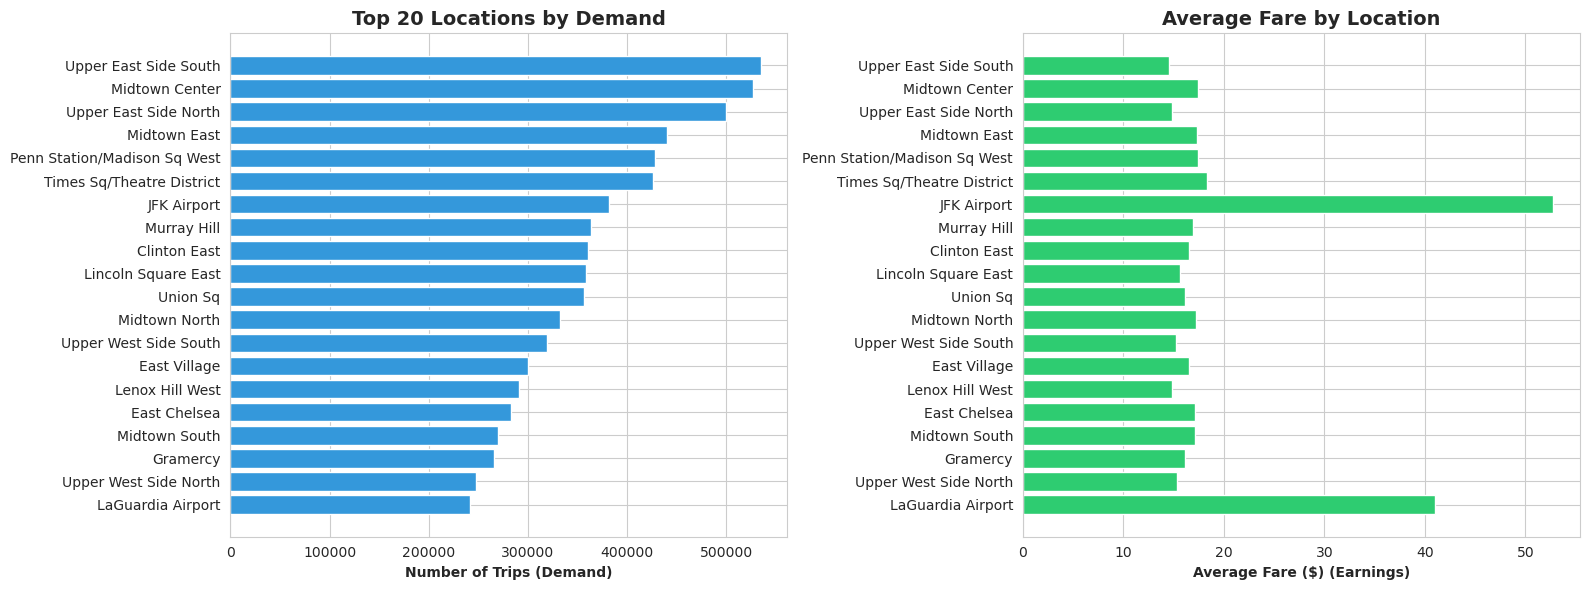

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # create 2 side-by-side subplots

# Left graph: Demand (trip volume)
ax1.barh(df_q1['zone_name'], df_q1['trip_count'], color='#3498db')  # horizontal bar: trip volume
ax1.set_xlabel('Number of Trips (Demand)', fontweight='bold')  # label x axis
ax1.set_title('Top 20 Locations by Demand', fontweight='bold', fontsize=14)  # chart title
ax1.invert_yaxis()  # highest values at top

# Right: Earnings (average fare)
ax2.barh(df_q1['zone_name'], df_q1['avg_fare'], color='#2ecc71')  # horizontal bar: avg fare
ax2.set_xlabel('Average Fare ($) (Earnings)', fontweight='bold')  # axis label
ax2.set_title('Average Fare by Location', fontweight='bold', fontsize=14)  # title
ax2.invert_yaxis()  # align orientation

plt.tight_layout()  # adjust spacing
plt.savefig('q1_demand_earnings.png')  # save figure as PNG

Business Implication/Interpretation: The best opportunities are in Upper East Side South and Midtown Center, which have both high demand (500K+ trips) and strong average fares ($17-18). JFK Airport offers the highest earnings per trip (USD53) but lower volume. Drivers seeking steady income should focus on Manhattan core zones, while those willing to wait for high-value rides should position near airports.

#### Q2: How does payment type affect tip amount?

SQL Query

In [55]:
con.sql("""
    SELECT
        pt.payment_type_name,
        COUNT(*) AS trip_count,  -- Total number of trips for each payment type
        
        -- Calculate average tip amount, rounded to 2 decimal places
        ROUND(AVG(TRY_CAST(f.tip_amount AS DECIMAL)), 2) AS avg_tip,
        
        -- Calculate average total fare, rounded to 2 decimal places
        ROUND(AVG(TRY_CAST(f.total_amount AS DECIMAL)), 2) AS avg_total_fare,
        
        -- Calculate tip as a percentage of total fare
        -- Formula: (avg_tip / avg_total_fare) * 100, rounded to 2 decimal places
        -- NULLIF prevents division by zero errors
        ROUND(AVG(TRY_CAST(f.tip_amount AS DECIMAL)) / 
              NULLIF(AVG(TRY_CAST(f.total_amount AS DECIMAL)), 0) * 100, 2) AS tip_percentage
        
    FROM fact_trips f  -- Main trips table
    
    -- Join with payment type dimension table to get payment type names
    JOIN dim_payment_type pt ON f.payment_type_key = pt.payment_type_key
    
    -- Group results by payment type to aggregate statistics
    GROUP BY pt.payment_type_name
    
    -- Sort results by number of trips in descending order
    ORDER BY trip_count DESC
""").df()

,payment_type_name,trip_count,avg_tip,avg_total_fare,tip_percentage
0,Credit Card,8819716,2.98,19.57,15.23
1,Cash,2910246,0.00,15.51,0.00
2,No Charge,60951,-0.00,9.91,-0.03
3,Dispute,34041,0.02,0.61,3.95
4,Unknown,1,0.00,0.00,NaN


This table compares tipping behavior across different payment types. Credit card trips make up the majority of rides and have the highest average tip at about $2.98, which represents roughly 15 percent of the total fare. Cash trips, which are the second most common, show zero recorded tips because cash tips are usually handed directly to the driver and are not captured in the electronic system. The categories “No Charge” and “Dispute” have very low fares and essentially no tips, which makes sense because these rides are free or contested. Overall, the results show that tipping behavior is strongly linked to electronic payments. Credit card transactions are transparent and automatically prompt passengers for tips, while cash tips remain invisible in the data.

Visualization

In [56]:
q2 = con.sql("""
    SELECT 
        pt.payment_type_name,
        COUNT(*) AS trip_count,
        ROUND(AVG(TRY_CAST(f.tip_amount AS DECIMAL)), 2) AS avg_tip,
        ROUND(AVG(TRY_CAST(f.total_amount AS DECIMAL)), 2) AS avg_total_fare,
        ROUND(AVG(TRY_CAST(f.tip_amount AS DECIMAL)) / 
              NULLIF(AVG(TRY_CAST(f.total_amount AS DECIMAL)), 0) * 100, 2) AS tip_percentage
    FROM fact_trips f
    JOIN dim_payment_type pt ON f.payment_type_key = pt.payment_type_key
    GROUP BY pt.payment_type_name
    ORDER BY trip_count DESC
""").df()

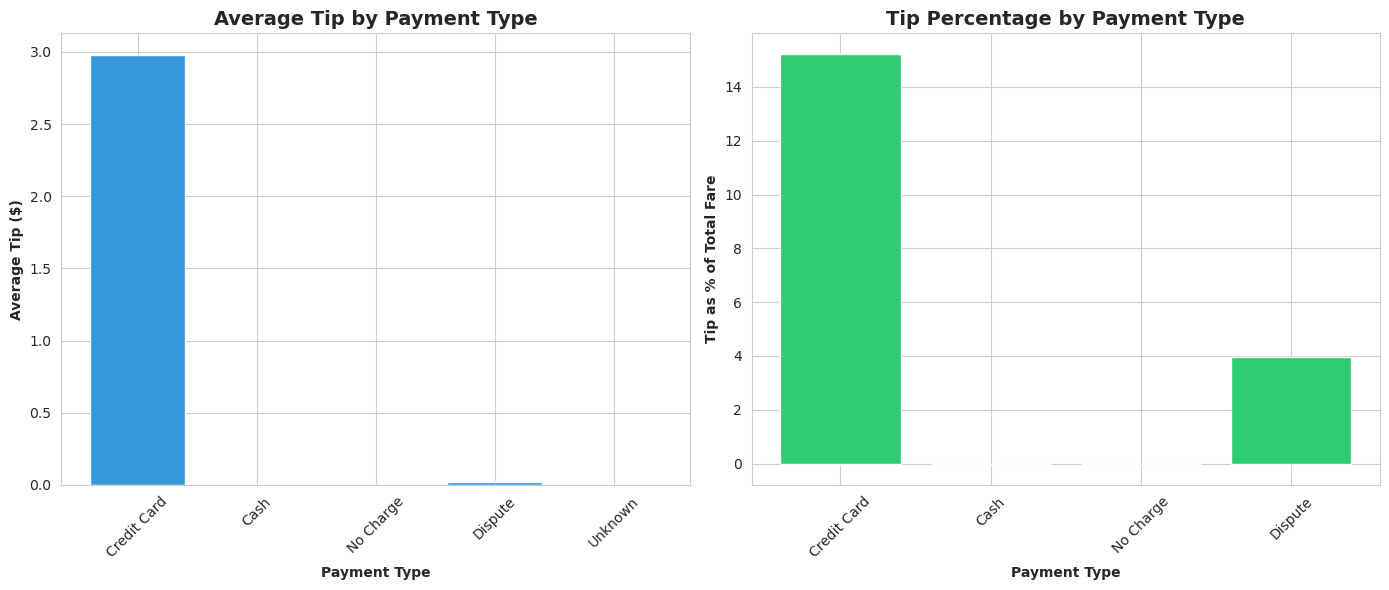

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Average tip amount
ax1.bar(q2['payment_type_name'], q2['avg_tip'], color='#3498db')
ax1.set_xlabel('Payment Type', fontweight='bold')
ax1.set_ylabel('Average Tip ($)', fontweight='bold')
ax1.set_title('Average Tip by Payment Type', fontweight='bold', fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# Right: Tip as percentage of fare
ax2.bar(q2['payment_type_name'], q2['tip_percentage'], color='#2ecc71')
ax2.set_xlabel('Payment Type', fontweight='bold')
ax2.set_ylabel('Tip as % of Total Fare', fontweight='bold')
ax2.set_title('Tip Percentage by Payment Type', fontweight='bold', fontsize=14)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('q2_payment_tips.png', dpi=300, bbox_inches='tight')
plt.show()

Business Implications/Interpretation: Credit card users show an average tip of 2.98 dollars (15.23% of fare), while cash payments show $0.00 tips. This doesn't mean cash customers don't tip, though. This is probably because cash tips aren't captured in the electronic payment system. Credit card payments provide better tip transparency and likely result in higher recorded tips since customers are prompted to tip at payment. When paying with cash, only the driver knows how much they got tipped. There's no electronic record of tips made in cash.

#### Q3: What percentage of revenue is consumed by mandatory fees? (Mandatory fees in NYC taxi data include: MTA tax, improvement surcharge, tolls, congestion surcharge,and extra)

SQL Query

In [67]:
# Query to analyze overall trip revenue breakdown and calculate mandatory fees
con.sql("""
    SELECT 
        COUNT(*) AS total_trips, -- Total number of trips in the dataset
        ROUND(SUM(TRY_CAST(f.total_amount AS DECIMAL)), 2) AS total_revenue, -- Total revenue collected from all trips
        ROUND(SUM(TRY_CAST(f.fare_amount AS DECIMAL)), 2) AS total_base_fare, -- Total base fare amount (before fees and tips)
        ROUND(SUM(TRY_CAST(f.tip_amount AS DECIMAL)), 2) AS total_tips, -- Total tips received from passengers
        ROUND(SUM(TRY_CAST(f.extra AS DECIMAL)), 2) AS total_extras, -- Total extra charges (e.g., rush hour, overnight surcharges)
        ROUND(SUM(TRY_CAST(f.tolls_amount AS DECIMAL)), 2) AS total_tolls, -- Total tolls paid during trips
        ROUND(SUM(TRY_CAST(f.mta_tax AS DECIMAL)), 2) AS total_mta_tax, -- Total MTA tax collected (New York Metropolitan Transportation Authority tax)
        ROUND(SUM(TRY_CAST(f.improvement_surcharge AS DECIMAL)), 2) AS total_improvement_surcharge, -- Total improvement surcharge (funds taxi infrastructure improvements)
        ROUND(SUM(TRY_CAST(f.congestion_surcharge AS DECIMAL)), 2) AS total_congestion_surcharge, -- Total congestion surcharge (charged for trips in congestion zones)
        ROUND(SUM(TRY_CAST(f.mta_tax AS DECIMAL) +  -- Sum of all mandatory government fees and surcharges
                  TRY_CAST(f.improvement_surcharge AS DECIMAL) + 
                  TRY_CAST(f.congestion_surcharge AS DECIMAL)), 2) AS total_mandatory_fees,
        ROUND((SUM(TRY_CAST(f.mta_tax AS DECIMAL) +  -- Calculate what percentage of total revenue comes from mandatory fees
                   TRY_CAST(f.improvement_surcharge AS DECIMAL) + 
                   TRY_CAST(f.congestion_surcharge AS DECIMAL)) /
               NULLIF(SUM(TRY_CAST(f.total_amount AS DECIMAL)), 0)) * 100, 2) AS mandatory_fee_percentage -- NULLIF prevents division by zero errors
    FROM fact_trips f -- Query data from the trips fact table
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,total_trips,total_revenue,total_base_fare,total_tips,total_extras,total_tolls,total_mta_tax,total_improvement_surcharge,total_congestion_surcharge,total_mandatory_fees,mandatory_fee_percentage
0,11890396,2.208015e+08,1.497019e+08,26298040.67,13144657.56,3992079.66,5862116.66,3542762.4,27233409.0,36638288.06,16.59


This summary shows how total revenue is distributed across different components of the fare. Out of about 220.8 million dollars in total revenue, the base fare accounts for the largest share, followed by tips and extra charges. Mandatory fees, which include MTA tax, the improvement surcharge, and the congestion surcharge, add up to about 36.6 million dollars. This means that roughly 16.6 percent of all passenger spending goes directly to fees rather than to the driver or the base fare. The numbers indicate that a significant portion of the taxi revenue is absorbed by taxes and surcharges, which reduces how much drivers take home. Although these fees support infrastructure and transportation programs, they contribute to higher passenger costs and lower driver earnings.

Visualization

In [59]:
q3 = con.sql("""
    SELECT 
        COUNT(*) AS total_trips,
        ROUND(SUM(TRY_CAST(f.total_amount AS DECIMAL)), 2) AS total_revenue,
        ROUND(SUM(TRY_CAST(f.fare_amount AS DECIMAL)), 2) AS total_base_fare,
        ROUND(SUM(TRY_CAST(f.tip_amount AS DECIMAL)), 2) AS total_tips,
        ROUND(SUM(TRY_CAST(f.extra AS DECIMAL)), 2) AS total_extras,
        ROUND(SUM(TRY_CAST(f.tolls_amount AS DECIMAL)), 2) AS total_tolls,
        ROUND(SUM(TRY_CAST(f.mta_tax AS DECIMAL)), 2) AS total_mta_tax,
        ROUND(SUM(TRY_CAST(f.improvement_surcharge AS DECIMAL)), 2) AS total_improvement_surcharge,
        ROUND(SUM(TRY_CAST(f.congestion_surcharge AS DECIMAL)), 2) AS total_congestion_surcharge,
        ROUND(SUM(TRY_CAST(f.mta_tax AS DECIMAL) + 
                  TRY_CAST(f.improvement_surcharge AS DECIMAL) + 
                  TRY_CAST(f.congestion_surcharge AS DECIMAL)), 2) AS total_mandatory_fees,
        ROUND((SUM(TRY_CAST(f.mta_tax AS DECIMAL) + 
                   TRY_CAST(f.improvement_surcharge AS DECIMAL) + 
                   TRY_CAST(f.congestion_surcharge AS DECIMAL)) /
               NULLIF(SUM(TRY_CAST(f.total_amount AS DECIMAL)), 0)) * 100, 2) AS mandatory_fee_percentage
    FROM fact_trips f
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

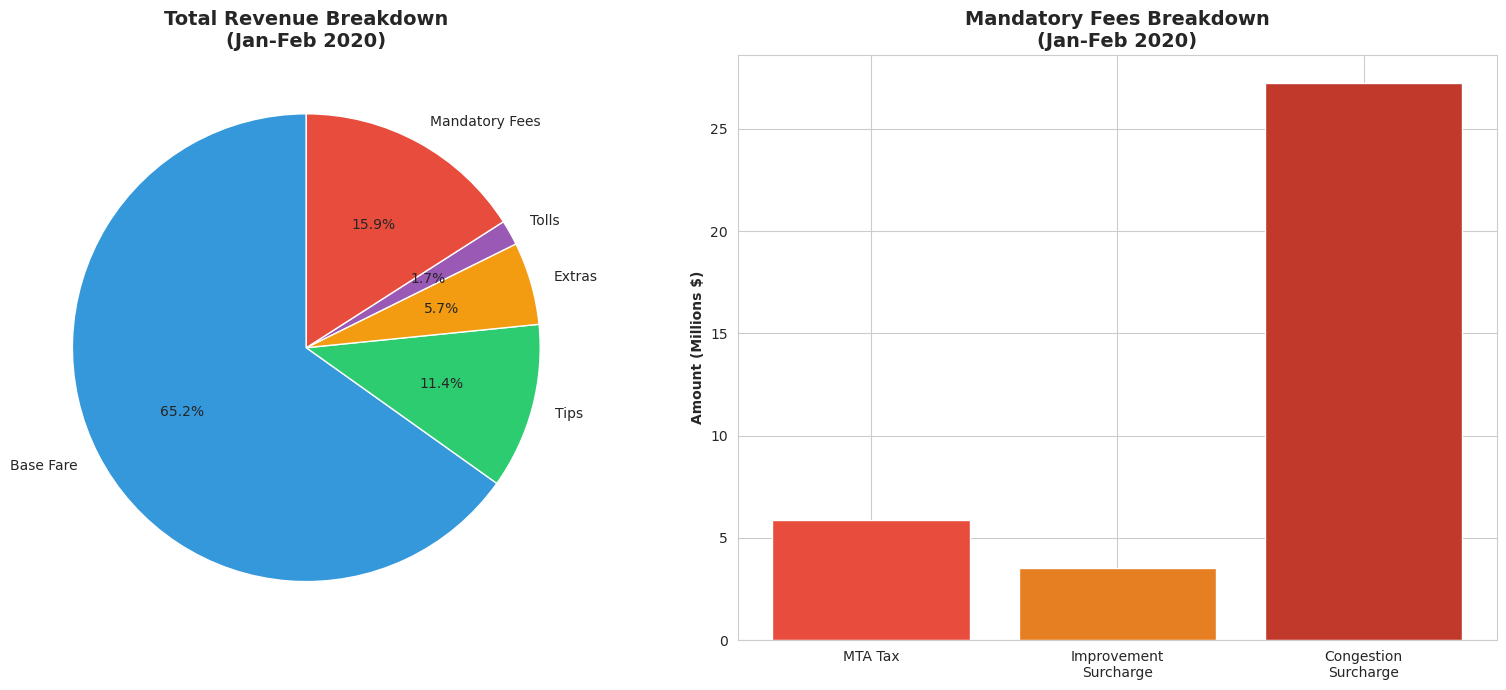

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: Pie chart of revenue components
revenue_components = {
    'Base Fare': q3['total_base_fare'].iloc[0],
    'Tips': q3['total_tips'].iloc[0],
    'Extras': q3['total_extras'].iloc[0],
    'Tolls': q3['total_tolls'].iloc[0],
    'Mandatory Fees': q3['total_mandatory_fees'].iloc[0]
}

colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#e74c3c']
ax1.pie(revenue_components.values(), 
        labels=revenue_components.keys(),
        autopct='%1.1f%%',
        colors=colors,
        startangle=90)
ax1.set_title('Total Revenue Breakdown\n(Jan-Feb 2020)', fontweight='bold', fontsize=14)

# Right: Bar chart of mandatory fees breakdown
fee_breakdown = {
    'MTA Tax': q3['total_mta_tax'].iloc[0],
    'Improvement\nSurcharge': q3['total_improvement_surcharge'].iloc[0],
    'Congestion\nSurcharge': q3['total_congestion_surcharge'].iloc[0]
}

ax2.bar(fee_breakdown.keys(), 
        [v/1e6 for v in fee_breakdown.values()],  # Convert to millions
        color=['#e74c3c', '#e67e22', '#c0392b'])
ax2.set_ylabel('Amount (Millions $)', fontweight='bold')
ax2.set_title('Mandatory Fees Breakdown\n(Jan-Feb 2020)', fontweight='bold', fontsize=14)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('q3_revenue_fees.png', dpi=300, bbox_inches='tight')
plt.show()

Business Implication/Interpretation: Mandatory fees make up 16.59 percent of all revenue collected between January and February, totaling 36.6 million dollars out of 220.8 million. This means that nearly one out of every six dollars paid by passengers never reaches the driver. It goes directly to taxes, tolls, and surcharges. The single largest contributor is the congestion surcharge, accounting for the majority of fee revenue, followed by MTA taxes and the improvement surcharge. From a business perspective, this fee structure significantly affects driver income and profitability. Even if the total revenue appears high, drivers receive substantially less after these deductions. For riders, these fees increase the cost of the trip without improving the perceived value of the ride, since they are not part of the base fare or tip. For fleet operators and policymakers, these findings highlight a potential tradeoff. Fees are achieving revenue goals, but they may be reducing driver earnings, which could influence driver availability, service quality, and the long-term sustainability of urban taxi services.

#### Q4: What time of day generates the highest revenue per trip?

SQL Query

In [61]:
# Now we want to find out what time o

con.sql("""
    SELECT
        CASE -- Categorize trips by time of day based on pickup hour
            WHEN pdt.hour BETWEEN 6 AND 11 THEN 'Morning' -- Morning: 6 AM to 11 AM
            WHEN pdt.hour BETWEEN 12 AND 17 THEN 'Afternoon' -- Afternoon: 12 PM to 5 PM
            WHEN pdt.hour BETWEEN 18 AND 21 THEN 'Evening' -- Evening: 6 PM to 9 PM
            ELSE 'Night' -- Night: 10 PM to 5 AM
        END AS time_of_day,
        COUNT(*) AS trip_count, -- Total number of trips for each time period
        ROUND(AVG(TRY_CAST(f.total_amount AS DECIMAL)), 2) AS avg_fare, -- Average fare per trip for each time period
        ROUND(AVG(TRY_CAST(f.trip_distance AS DECIMAL)), 2) AS avg_distance -- Average trip distance for each time period
    FROM fact_trips f -- Query data from the trips fact table
    JOIN dim_datetime pdt ON f.pickup_datetime_key = pdt.datetime_key -- Join with datetime dimension to get pickup hour
    GROUP BY time_of_day -- Group results by time of day category
    ORDER BY -- Sort results for custom display order
        CASE time_of_day
            WHEN 'Morning' THEN 1 -- Display Morning first
            WHEN 'Afternoon' THEN 2 -- Display Afternoon second
            WHEN 'Evening' THEN 3 -- Display Evening third
            WHEN 'Night' THEN 4 -- Display Night fourth
        END
""").df()

,time_of_day,trip_count,avg_fare,avg_distance
0,Morning,2933945,17.66,2.70
1,Afternoon,4060623,18.72,2.77
2,Evening,2864760,18.71,2.83
3,Night,2031068,19.39,3.35


This result groups trips by time of day and compares the number of rides, average fare, and average distance. The afternoon has the highest trip volume, followed by the morning and evening, showing that daytime hours are the busiest. However, the highest average fare and longest average distance occur at night, when trips cost about $19.39 on average and cover more than 3.3 miles. This makes sense because nighttime travel often includes airport runs, longer trips across the city, and fewer short local rides. Overall, the data shows that daytime brings more rides, but nighttime generates the highest revenue per trip.

Visualization

In [62]:
q4 = con.sql("""
    SELECT 
        CASE
            WHEN pdt.hour BETWEEN 6 AND 11 THEN 'Morning'
            WHEN pdt.hour BETWEEN 12 AND 17 THEN 'Afternoon'
            WHEN pdt.hour BETWEEN 18 AND 21 THEN 'Evening'
            ELSE 'Night'
        END AS time_of_day,
        COUNT(*) AS trip_count,
        ROUND(AVG(TRY_CAST(f.total_amount AS DECIMAL)), 2) AS avg_fare,
        ROUND(AVG(TRY_CAST(f.trip_distance AS DECIMAL)), 2) AS avg_distance
    FROM fact_trips f
    JOIN dim_datetime pdt ON f.pickup_datetime_key = pdt.datetime_key
    GROUP BY time_of_day
    ORDER BY 
        CASE time_of_day
            WHEN 'Morning' THEN 1
            WHEN 'Afternoon' THEN 2
            WHEN 'Evening' THEN 3
            WHEN 'Night' THEN 4
        END
""").df()

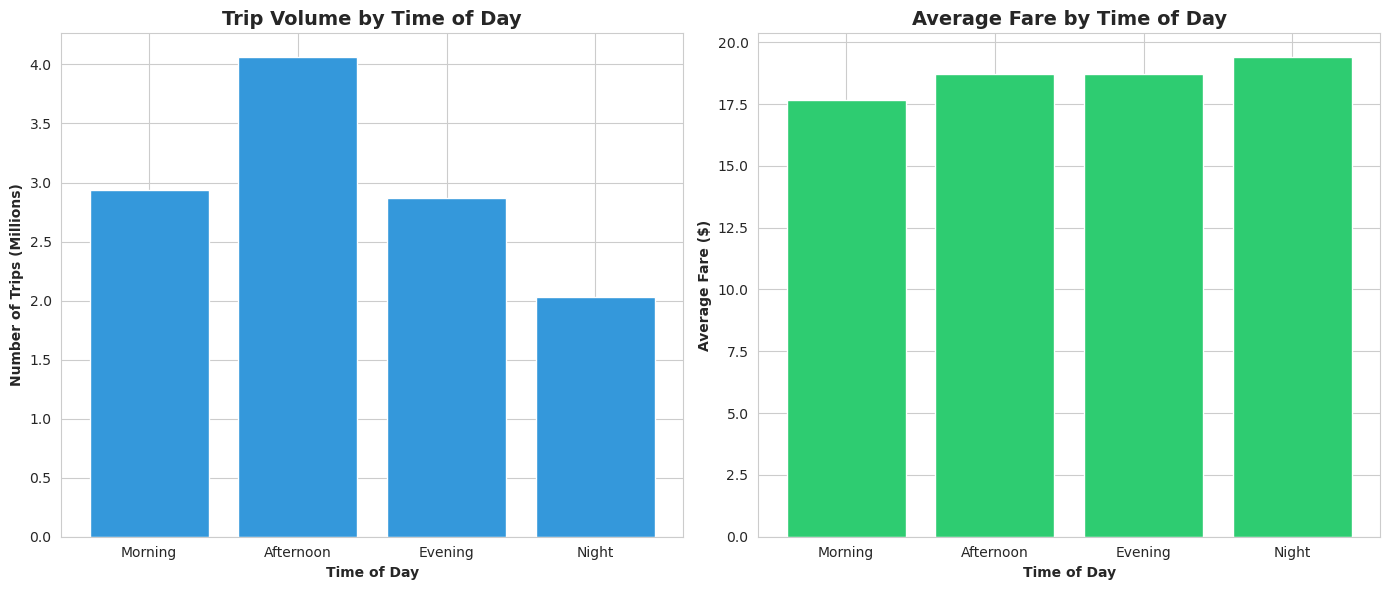

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Trip volume by time of day
ax1.bar(q4['time_of_day'], q4['trip_count']/1e6, color='#3498db')
ax1.set_xlabel('Time of Day', fontweight='bold')
ax1.set_ylabel('Number of Trips (Millions)', fontweight='bold')
ax1.set_title('Trip Volume by Time of Day', fontweight='bold', fontsize=14)

# Right: Average fare by time of day
ax2.bar(q4['time_of_day'], q4['avg_fare'], color='#2ecc71')
ax2.set_xlabel('Time of Day', fontweight='bold')
ax2.set_ylabel('Average Fare ($)', fontweight='bold')
ax2.set_title('Average Fare by Time of Day', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('q4_time_of_day.png', dpi=300, bbox_inches='tight')
plt.show()

Business Implications/Interpretation: Night shifts generate the highest revenue per trip at 19.39 dollars average fare with the longest distances (3.35 miles), probably due to reduced taxi availability and longer trips to livlier nightly destinations, though they have the lowest volume at 2 million trips. Afternoon has the highest demand with 4.06 million trips and strong fares at 18.72 dollars, making it ideal for drivers seeking steady income through consistent customer flow. Morning shifts offer the lowest earnings at 17.66 dollars per trip with shorter distances (2.70 miles), typical of quick commuter rides. For maximum profitability, drivers should focus on night and afternoon shifts, as night provides 10% higher fares than morning while afternoon balances high volume with some really competitive pricing.

## Business Summary

Our analysis of New York City taxi activity reveals a clear economic landscape across location, payment behavior, mandatory fee structures, and time-of-day performance. Demand is overwhelmingly concentrated in Manhattan, particularly in zones such as the Upper East Side, Midtown Center, and Times Square, where trip volumes consistently exceed 300,000 rides. These areas offer frequent short-distance trips with predictable earnings, while airports such as JFK and LaGuardia, though lower in volume, provide the highest-value trips with fares ranging from 40 to over 50 dollars. We also found that payment method strongly shapes tipping behavior: credit card rides produce an average tip of nearly three dollars (about 15 percent of the fare), while cash transactions do not show tips in the data, highlighting how digital payments encourage higher and more consistent gratuity. Revenue analysis shows that mandatory fees consume more than 16 percent of total rider spending, meaning a significant portion of money paid by passengers never reaches drivers. Finally, time-of-day patterns reveal that afternoons generate the highest overall demand, while nights produce the most profitable trips on a per-ride basis due to longer distances and fewer short commutes.

Together, these insights paint a clear picture of how taxi drivers can maximize income: positioning in central Manhattan ensures steady trip volume, airport staging delivers high-value rides, credit card payments boost recorded tips, and night shifts offer the strongest earnings per trip despite lower overall demand.

Actionable Strategies for Taxi Drivers:

    Smart Positioning with Dynamic Zone Targeting:

To maximize earnings and reduce idle time, taxi drivers can adopt a smart positioning strategy based on location demand patterns. During peak daytime hours, zones like Midtown, Times Square, and the Upper East Side offer dense ride volumes with strong fare consistency. At night, drivers can reposition toward airports and nightlife hubs, where trips are longer and more lucrative, and ride-hailing apps often surge due to limited availability. By aligning their location with time-based demand trends, drivers can operate more efficiently and competitively.

    Promote Digital Payments and “Tip-Friendly” Experiences:

Because credit card transactions generate significantly higher recorded tips, drivers can actively encourage passengers to pay electronically by highlighting convenience, safety, and receipt availability. Simple in-cab messaging such as “Tap to pay—fastest and includes recommended tip options” can subtly shift riders toward digital payment. This creates a tipping experience similar to Uber and Lyft, where the interface prompts customers to tip by default.


## Part IV: Presentation

A complete presentation summarizing our analytical process, dimensional model, SQL findings, and business insights has been prepared and delivered as part of this project. The accompanying PowerPoint slide deck is included with the submission